In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import rotate_about_point

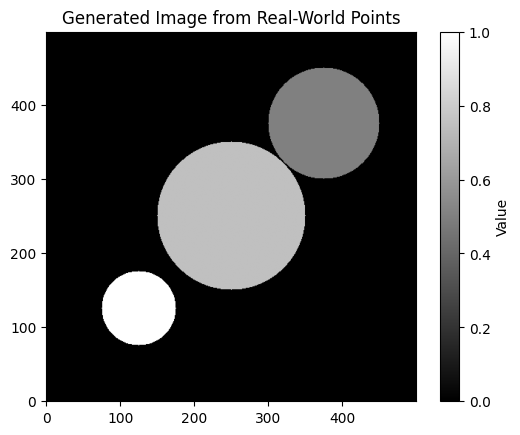

In [5]:


def create_image_from_points(image_width_pixels, real_width_meters, points):
    # Create an empty image (2D array) initialized to zero
    image = np.zeros((image_width_pixels, image_width_pixels))
    
    # Calculate the scaling factor from meters to pixels
    scale = image_width_pixels / real_width_meters

    for point in points:
        x_real, y_real, radius_real, value = point
        
        # Convert real-world coordinates to image coordinates (pixels)
        x_pixel = int(x_real * scale)
        y_pixel = int(y_real * scale)
        radius_pixel = int(radius_real * scale)
        
        # Create a mask for the circle in the image
        y, x = np.ogrid[-y_pixel:image_width_pixels-y_pixel, -x_pixel:image_width_pixels-x_pixel]
        mask = x*x + y*y <= radius_pixel*radius_pixel
        
        # Fill in the pixels within the radius with the specified value
        image[mask] = value
    
    return image

# Parameters
image_width_pixels = 500  # Image width in pixels
real_width_meters = 10.0  # Real-world width in meters

# Example points (x_real, y_real, radius_real, value)
points = [
    (2.5, 2.5, 1.0, 1.0),
    (7.5, 7.5, 1.5, 0.5),
    (5.0, 5.0, 2.0, 0.75)
]

# Create the image
image = create_image_from_points(image_width_pixels, real_width_meters, points)

# Display the image
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar(label='Value')
plt.title('Generated Image from Real-World Points')
plt.show()


Toy Measurement Control Initialized
[0.61814408 0.5948777  0.37215425 0.41482397]


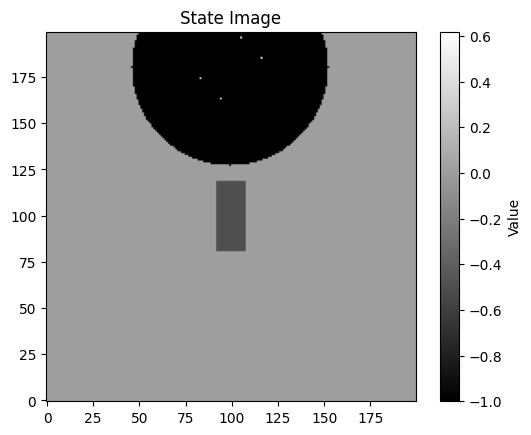

In [7]:
# Create state image from car position, OOI corners, car width, car_length and obstacles
def get_image_based_state(state, car_width, car_length, obstacle_means, obstacle_radii, width_pixels=200, width_meters=50):
    # Pull out the state components
    car_state, corner_means, corner_covariance, horizon = state
    corner_means = corner_means.reshape(-1, 2) # Reshape to 2D array where each row is a corner point
    
    # Get normalized point covariances
    pt_traces = tmc.get_normalized_cov_pt_traces(state)
    
    # Since image is body frame representation of car, obstacles and OOIs. The neural net only needs [vx, delta, delta_dot] as input
    # These are the components of the state which will determine how actions effect the car state, the rest of the state is used to generate the image
    nn_car_state = car_state[[2, 4, 5]]
    
    # Make the image
    image = np.zeros((width_pixels, width_pixels), dtype=np.float32)
    
    # Calculate the scaling factor from meters to pixels
    scale = width_pixels / width_meters
    
    # Rotate the obstacle and corner points to the car's yaw angle
    car_pos, car_yaw = car_state[:2], car_state[3]
    rotated_corners = rotate_about_point(corner_means, np.pi/2-car_yaw, car_pos) # Negative to rotate into a coordinate system where the car is facing up
    rotated_obstacles = rotate_about_point(obstacle_means, np.pi/2-car_yaw, car_pos)
    
    # Subtract the car's position from the rotated points to get the points relative to the car
    rotated_corners -= car_state[:2]
    rotated_obstacles -= car_state[:2]
    
    # Find which points are within the image bounds
    in_bounds_corners = (-width_meters/2 <= rotated_corners[:, 0]) & (rotated_corners[:, 0] <= width_meters/2) & \
                        (-width_meters/2 <= rotated_corners[:, 1]) & (rotated_corners[:, 1] <= width_meters/2)

    in_bounds_obstacles = (-width_meters/2 <= rotated_obstacles[:, 0]) & (rotated_obstacles[:, 0] <= width_meters/2) & \
                          (-width_meters/2 <= rotated_obstacles[:, 1]) & (rotated_obstacles[:, 1] <= width_meters/2)

    # Convert the car frame in bounds points to pixel coordinates
    in_bounds_corner_pixels = (rotated_corners[in_bounds_corners] * scale + width_pixels / 2).astype(int)
    in_bounds_obstacle_pixels = (rotated_obstacles[in_bounds_obstacles] * scale + width_pixels / 2).astype(int)
    in_bounds_obstacle_radii_pixels = (obstacle_radii[in_bounds_obstacles] * scale).astype(int)
    
    # First place obstacles so that rewards and car overlay them
    for i, point in enumerate(in_bounds_obstacle_pixels):
        x_pixel, y_pixel = point
        radius_pixel = in_bounds_obstacle_radii_pixels[i]
        x, y = np.ogrid[-x_pixel:width_pixels-x_pixel, -y_pixel:width_pixels-y_pixel]
        mask = x*x + y*y <= radius_pixel*radius_pixel
        image[mask] = -1.0
        
    # Place the car (draw a rectangle at the center given length and width), car is always facing up (positive x axis)
    car_width_pixels = int(car_width * scale)
    car_length_pixels = int(car_length * scale)
    car_max_x_index = car_width_pixels + width_pixels // 2
    car_max_y_index = car_length_pixels + width_pixels // 2
    image[-car_max_x_index:car_max_x_index, -car_max_y_index:car_max_y_index] = -0.5
    
    # Place the corners
    image[in_bounds_corner_pixels[:, 0], in_bounds_corner_pixels[:, 1]] = pt_traces[in_bounds_corners]
        
    # Return the neural net state and the image
    return nn_car_state, image

def plot_state_image(image, title):
    plt.imshow(image.T, cmap='gray', origin='lower')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.show()
    
# Make a toy measurement control object (environment for MCTS)
tmc = MeasurementControlEnvironment(no_flask_server=True, enable_ui=False)

# Get car collision length and width
car_width, car_length = tmc.car.width, tmc.car.length

nn_state, image = get_image_based_state(tmc.get_state(), car_width, car_length, tmc.eval_kd_tree.get_obstacle_points(), tmc.eval_kd_tree.get_obstacle_radii())
plot_state_image(image, 'State Image')